Total de pacientes en el dataset: 426
Pacientes con datos tanto en mes 0 como en mes 24: 426

Distribución de pacientes por clasificación en EDSS:
clasif_EDSS
Estable o mejora    259
Sin datos           152
Empeoramiento        15
Name: count, dtype: int64


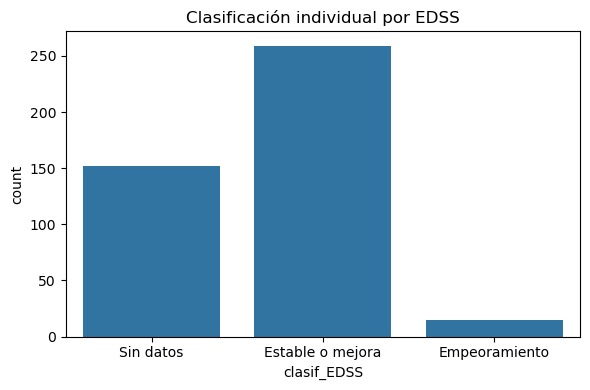


Distribución de pacientes por clasificación en T25WT (sec):
clasif_T25WT (sec)
Sin datos           198
Estable o mejora    142
Empeoramiento        86
Name: count, dtype: int64


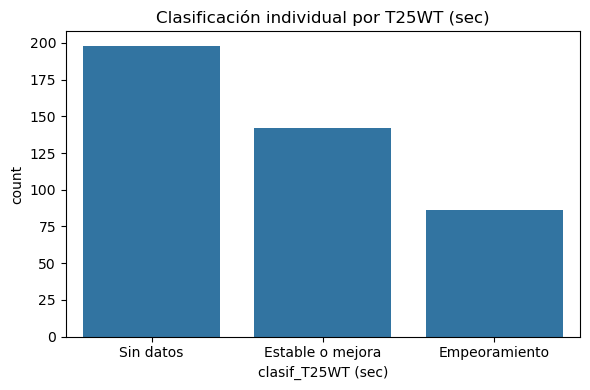


Distribución de pacientes por clasificación en 9HPT right hand (sec):
clasif_9HPT right hand (sec)
Estable o mejora    213
Sin datos           192
Empeoramiento        21
Name: count, dtype: int64


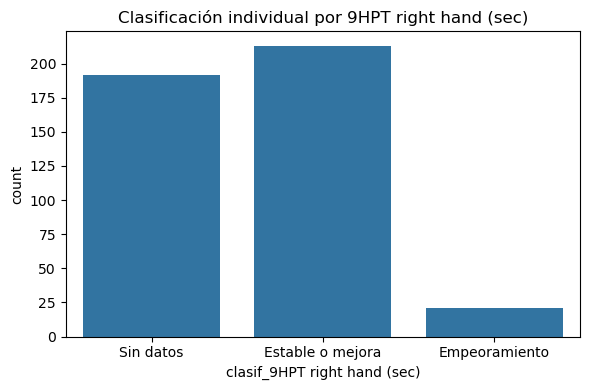


Distribución de pacientes por clasificación en 9HPT Left hand (sec):
clasif_9HPT Left hand (sec)
Estable o mejora    207
Sin datos           192
Empeoramiento        27
Name: count, dtype: int64


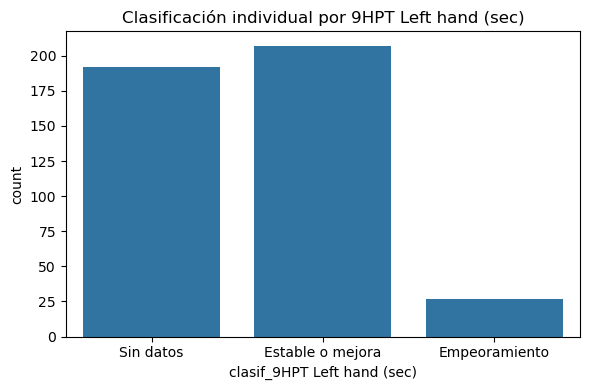


Distribución de pacientes por clasificación en 2.5LCVA, right eye:
clasif_2.5LCVA, right eye
Sin datos           203
Estable o mejora    114
Empeoramiento       109
Name: count, dtype: int64


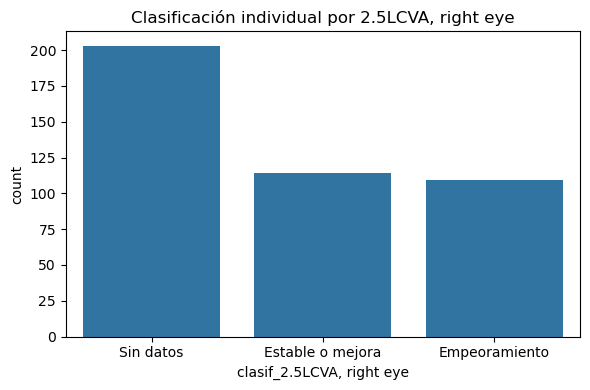


Distribución de pacientes por clasificación en 2.5LCVA, left eye:
clasif_2.5LCVA, left eye
Sin datos           206
Empeoramiento       114
Estable o mejora    106
Name: count, dtype: int64


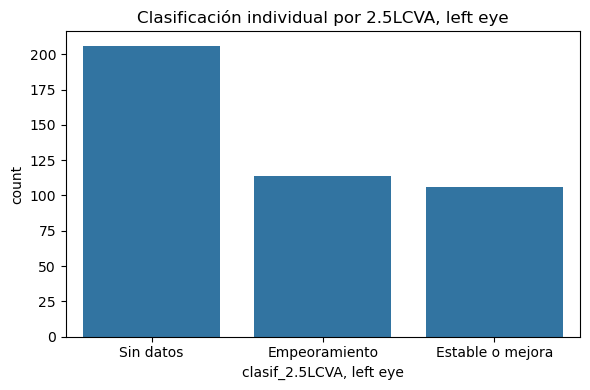


Distribución de pacientes por clasificación en SDMT:
clasif_SDMT
Estable o mejora    194
Sin datos           184
Empeoramiento        48
Name: count, dtype: int64


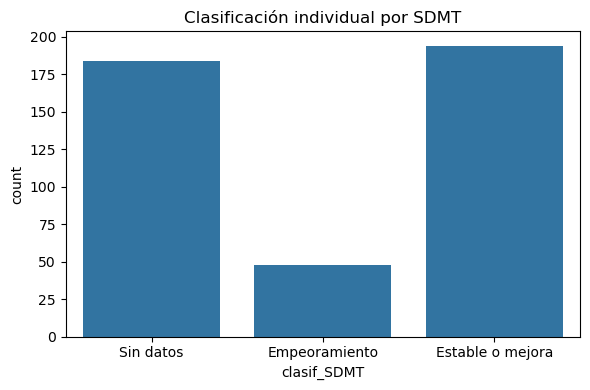


Tabla resumen de evolución por paciente (valores mes 0, mes 24 y delta):
  Redcap Identification number  EDSS_0  EDSS_24  delta_EDSS  T25WT (sec)_0  \
0                          1-1     NaN      NaN         NaN            NaN   
1                         1-10     5.0      5.0         0.0           6.22   
2                         1-11     3.0      2.0        -1.0           3.49   
3                         1-12     1.5      2.5         1.0           4.24   
4                         1-13     6.0      3.5        -2.5           9.77   

   T25WT (sec)_24  delta_T25WT (sec)  9HPT right hand (sec)_0  \
0             NaN                NaN                      NaN   
1           5.860             -0.360                    21.89   
2             NaN                NaN                    16.72   
3             NaN                NaN                    18.03   
4           6.755             -3.015                    25.23   

   9HPT right hand (sec)_24  delta_9HPT right hand (sec)  ...  \
0

In [1]:
# --- LIBRERIAS ---
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from math import pi

# --- CARGA DE DATOS Y RESUMEN INICIAL ---
df = pd.read_csv("sys4ms_data/sys4ms_clinical_baseline.csv")
df["month"] = df["Event Name"].str.extract(r"Month (\d+)|Baseline").fillna("0")
df["month"] = df["month"].replace("Baseline", "0").astype(int)

# Filtrar pacientes con mes 0 y mes 24
counts = df.groupby("Redcap Identification number")["month"].nunique()
valid_ids = counts[counts == 2].index
df = df[df["Redcap Identification number"].isin(valid_ids)]

print(f"Total de pacientes en el dataset: {df['Redcap Identification number'].nunique()}")
print(f"Pacientes con datos tanto en mes 0 como en mes 24: {len(valid_ids)}")

# Variables clave a estudiar con nombres reales
variables_clave = [
    "EDSS",
    "T25WT (sec)",
    "9HPT right hand (sec)",
    "9HPT Left hand (sec)",
    "2.5LCVA, right eye",
    "2.5LCVA, left eye",
    "SDMT"
]

# Pivot y cálculo de deltas
df_pivot = df.pivot(index="Redcap Identification number", columns="month", values=variables_clave)
df_pivot.columns = [f"{col}_{month}" for col, month in df_pivot.columns]
df_pivot.reset_index(inplace=True)

for var in variables_clave:
    col_0 = f"{var}_0"
    col_24 = f"{var}_24"
    if col_0 in df_pivot.columns and col_24 in df_pivot.columns:
        df_pivot[f"delta_{var}"] = df_pivot[col_24] - df_pivot[col_0]
        df_pivot[f"pct_change_{var}"] = ((df_pivot[col_24] - df_pivot[col_0]) / df_pivot[col_0]).abs()

# Clasificación variable por variable
for var in variables_clave:
    trend_col = f"clasif_{var}"
    delta_col = f"delta_{var}" if var == "EDSS" else f"pct_change_{var}"

    def clasif_individual(x):
        if pd.isna(x): return "Sin datos"
        if var == "EDSS":
            return "Empeoramiento" if x > 1 else "Estable o mejora"
        else:
            return "Empeoramiento" if x > 0.2 else "Estable o mejora"

    df_pivot[trend_col] = df_pivot[delta_col].apply(clasif_individual)

    print(f"\nDistribución de pacientes por clasificación en {var}:")
    print(df_pivot[trend_col].value_counts())

    plt.figure(figsize=(6, 4))
    sns.countplot(x=trend_col, data=df_pivot)
    plt.title(f"Clasificación individual por {var}")
    plt.tight_layout()
    plt.show()

# --- TABLA RESUMEN VISUAL ---
columnas_resumen = ["Redcap Identification number"]
for var in variables_clave:
    columnas_resumen.extend([f"{var}_0", f"{var}_24", f"delta_{var}"])

tabla_resumen = df_pivot[columnas_resumen]
print("\nTabla resumen de evolución por paciente (valores mes 0, mes 24 y delta):")
print(tabla_resumen.head())

# Opcional: exportar
# tabla_resumen.to_csv("tabla_resumen_pacientes.csv", index=False)
